# Daegu Deals: What’s the Real Price of Home?
Main Goal: Using machine learning to help real estate company price Daegu apartments more accurately and confidently.

## Business Problem Understanding

### Business Context
Daegu is growing fast, and apartments are one of the most in-demand types of housing. But figuring out how much a unit should sell for isn’t always easy. A price that’s too high could scare off buyers. Too low, and real estate company might leave money on the table.

That’s where data comes in. Instead of relying purely on gut feeling or rough comparisons, we can use machine learning to analyse key property features like size, age, location, and nearby amenities to predict prices more accurately. This gives real estate company a solid, data-backed starting point when listing a property.

### Problem Statement
Right now, many apartment prices are based on intuition or basic comparisons, which can lead to overpricing or underpricing. This not only affects how quickly properties sell but also impacts profits and customer trust.

We want to fix that by building a machine learning model that predicts sale prices for apartments in Daegu. The goal is to give real estate company a smarter way to understand market value and help them list properties at the right price from day one.

### Goals
- Create a machine learning model to predict apartment sale prices.
- Figure out which features like floor size, distance to the subway, or number of nearby facilities really drive price.
- Provide insights that help real estate company make better pricing decisions.
- Lay the groundwork for a simple pricing tool real estate teams can use every day.

### Analytic Approach

1. **Data Understanding**
   - Explore trends and distributions in the data.
   - Clean up any missing values or unusual data points.
   - Visualise relationships between features and sale prices.

2. **Data Preprocessing:**
   - Encode and scale variables to get everything model-ready.
   - Log-transform the target variable for a smoother distribution.
   - Add polynomial features where it makes sense to capture non-linear trends.

3. **Feature Engineering:**
   - Remove features that are too similar to each other to avoid overlap.
   - Focus on what really adds value to the prediction.

4. **Modeling:**
   - Try out several models: Random Forest, Gradient Boosting, XGBoost, CatBoost, SVR, Ridge, and HistGradientBoosting.
   - Use cross-validation to check how well each model performs on unseen data.

5. **Evaluation:**
   - Use metrics like MAE, RMSE, R², and MAPE to see how accurate the predictions are.
   - Choose the model that gives the most consistent, reliable results.

6. **Insights & Next Steps:**
   - Use explainable AI tools (like SHAP) to break down what features are driving price predictions.
   - Turn those insights into practical tips for pricing apartments smarter.

### Evaluation Metrics

Since we are predicting continuous values (apartment prices), we will use the following **regression metrics**:

- **Mean Absolute Error (MAE):**  
  Measures the average magnitude of the errors in predictions. It’s straightforward to understand, representing the average amount our model’s predictions are off by.

- **Root Mean Squared Error (RMSE):**  
  Similar to MAE, but gives higher weight to larger errors, making it more sensitive to significant mispricing.

- **R² Score (Coefficient of Determination):**  
  Shows how much of the variation in apartment prices our model can explain. A higher R² indicates a better fit of the model to the data.

- **Mean Absolute Percentage Error (MAPE):**
  Expresses prediction accuracy as a percentage. It shows the average error as a proportion of actual values, making it easier to interpret relative errors across different price ranges.

### Business Perspective on Errors

From a business standpoint, the errors in our price predictions can have the following consequences:

- **Overpricing (predicting too high):**
  - Consequence: Unsold properties tie up capital and inventory. Extended listing periods mean ongoing costs such as property taxes, maintenance, and opportunity loss. Frequent price cuts can also damage the real estate company’s credibility.

- **Underpricing (predicting too low):**
  - Consequence: While units may sell quickly, real estate company sacrifices potential revenue and commissions. It also sets a lower pricing benchmark for similar listings, affecting future margins.

### Objective

We’re not just trying to build a smart model. We’re aiming to make apartment pricing easier, faster, and more accurate for real estate professionals in Daegu. By minimising both under- and overpricing errors, we’re helping real estate company sell smarter and deliver more value to their buyers.

## Data Understanding

Dataset source : https://drive.google.com/drive/folders/1fmkyfjrzuJNaH02sXhp5vUxqum9bH0Fx

**Note:**
- Most features are numeric (Float and Integer), with some high cardinality.
- Each row represents an apartment listing with features related to its sale.

### Attribute Information

| Attribute                           | Data Type         | Description |
| ------------------------------------ | ----------------- | ----------- |
| HallwayType                         | Categorical       | Type of apartment (e.g., hallway, penthouse, etc.) |
| TimeToSubway                         | Categorical       | Time in minutes needed to reach the nearest subway station |
| SubwayStation                        | Categorical       | Name of the nearest subway station |
| N_FacilitiesNearBy(ETC)              | Numeric (Float) | Number of miscellaneous facilities near the apartment |
| N_FacilitiesNearBy(PublicOffice)     | Numeric (Float) | Number of public office facilities near the apartment |
| N_SchoolNearBy(University)          | Numeric (Float) | Number of universities near the apartment |
| N_Parkinglot(Basement)              | Numeric (Float) | Number of basement parking lots available for the apartment |
| YearBuilt                            | Numeric (Integer) | Year the apartment building was constructed |
| N_FacilitiesInApt                   | Numeric (Integer) | Number of facilities within the apartment itself |
| Size(sqft)                           | Numeric (Integer)   | Size of the apartment in square feet |
| SalePrice                           | Numeric (Integer)   | Sale price of the apartment in Korean Won (target variable) |

In [159]:
# Data manipulation and analysis:
import pandas as pd
import numpy as np
import joblib
import shap
import pickle

# Visualisation:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px
from IPython.display import display

# Feature engineering and preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from category_encoders import TargetEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import RFECV

# Model selection:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

# Model evaluation:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

# Data splitting and cross validation:
from sklearn.model_selection import train_test_split, cross_val_score

# Ignore warnings:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns for Pandas:
pd.set_option('display.max_columns', None)

In [160]:
# Load Dataset:
df = pd.read_csv("data_daegu_apartment.csv")
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [161]:
df.describe()

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000
mean,1.930876,4.135338,2.746301,568.979141,2002.999757,5.817851,954.630851,221767.926995
std,2.198832,1.802640,1.496610,410.372742,8.905768,2.340507,383.805648,106739.839945
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,184.000000,1993.000000,4.000000,644.000000,144752.000000
50%,1.000000,5.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,209734.000000
75%,5.000000,5.000000,4.000000,798.000000,2008.000000,7.000000,1149.000000,291150.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


A few things stood out about the numeric columns:

- YearBuilt ranges from 1978 to 2015, with a median year of 2006 so most properties were built in the 2000s, which makes sense for a relatively modern housing dataset.
- Size(sqf) varies a lot from 135 sqft up to 2337 sqft with a median around 910 sqft, which likely reflects a mix of studio apartments and larger units.
- SalePrice spans from about ₩32,743 to ₩585,840, with a median price of ₩209,734. There’s a wide range here, which could be useful for modeling but also suggests we might want to handle outliers carefully.
- Features like N_FacilitiesNearBy(PublicOffice) and N_FacilitiesInApt show moderate variation, while N_Parkinglot(Basement) has a huge spread, probably because it's measured in square footage rather than count.

In [162]:
# General information on dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   HallwayType                       4123 non-null   object 
 1   TimeToSubway                      4123 non-null   object 
 2   SubwayStation                     4123 non-null   object 
 3   N_FacilitiesNearBy(ETC)           4123 non-null   float64
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   float64
 5   N_SchoolNearBy(University)        4123 non-null   float64
 6   N_Parkinglot(Basement)            4123 non-null   float64
 7   YearBuilt                         4123 non-null   int64  
 8   N_FacilitiesInApt                 4123 non-null   int64  
 9   Size(sqf)                         4123 non-null   int64  
 10  SalePrice                         4123 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 354.4+ KB


## Data Cleaning

In [163]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,HallwayType,object,0,0.0,3,"[corridor, mixed]"
1,TimeToSubway,object,0,0.0,5,"[5min~10min, 10min~15min]"
2,SubwayStation,object,0,0.0,8,"[Chil-sung-market, Myung-duk]"
3,N_FacilitiesNearBy(ETC),float64,0,0.0,4,"[1.0, 0.0]"
4,N_FacilitiesNearBy(PublicOffice),float64,0,0.0,8,"[1.0, 6.0]"
5,N_SchoolNearBy(University),float64,0,0.0,6,"[5.0, 0.0]"
6,N_Parkinglot(Basement),float64,0,0.0,20,"[56.0, 930.0]"
7,YearBuilt,int64,0,0.0,16,"[1986, 1985]"
8,N_FacilitiesInApt,int64,0,0.0,9,"[4, 8]"
9,Size(sqf),int64,0,0.0,89,"[281, 277]"


In [164]:
# Check for duplicates:
df.duplicated().sum()

1422

We found that 1,422 out of 4,123 rows (~34%) in the dataset were exact duplicates. Since repeated records can bias the model and lead it to overemphasise certain patterns, it made sense to drop them. This helps ensure the model learns from a cleaner, more balanced, and representative dataset.

In [165]:
# Drop duplicates:
df = df.drop_duplicates()

In [166]:
# Check inconsistent entries:
df['HallwayType'].value_counts()

HallwayType
terraced    1667
mixed        698
corridor     336
Name: count, dtype: int64

In [167]:
# Standardise HallwayType format:
df['HallwayType'] = df['HallwayType'].str.capitalize()
df['HallwayType'].value_counts()

HallwayType
Terraced    1667
Mixed        698
Corridor     336
Name: count, dtype: int64

In [168]:
# Check inconsistent entries:
df['TimeToSubway'].value_counts()

TimeToSubway
0-5min                1248
5min~10min             501
10min~15min            434
15min~20min            418
no_bus_stop_nearby     100
Name: count, dtype: int64

In [169]:
# Standardise TimeToSubway format:
df['TimeToSubway'] = df['TimeToSubway'].str.replace('~', '-')
df['TimeToSubway'] = df['TimeToSubway'].replace({'no_bus_stop_nearby': 'No Bus Stop Nearby'})
df['TimeToSubway'].value_counts()

TimeToSubway
0-5min                1248
5min-10min             501
10min-15min            434
15min-20min            418
No Bus Stop Nearby     100
Name: count, dtype: int64

In [170]:
# Check inconsistent entries:
df['SubwayStation'].value_counts()

SubwayStation
Myung-duk                709
Kyungbuk_uni_hospital    692
Sin-nam                  380
Banwoldang               333
Bangoge                  280
no_subway_nearby         188
Chil-sung-market          65
Daegu                     54
Name: count, dtype: int64

In [171]:
# Standardise SubwayStation format:
subway_rename_map = {
    'Myung-duk': 'Myung-duk',
    'Kyungbuk_uni_hospital': 'Kyungbuk Uni Hospital',
    'Sin-nam': 'Sin-nam',
    'Banwoldang': 'Banwoldang',
    'Bangoge': 'Bangoge',
    'no_subway_nearby': 'No Subway Nearby',
    'Chil-sung-market': 'Chil-sung Market',
    'Daegu': 'Daegu'
}

df['SubwayStation'] = df['SubwayStation'].replace(subway_rename_map)
df['SubwayStation'].value_counts()

SubwayStation
Myung-duk                709
Kyungbuk Uni Hospital    692
Sin-nam                  380
Banwoldang               333
Bangoge                  280
No Subway Nearby         188
Chil-sung Market          65
Daegu                     54
Name: count, dtype: int64

In [172]:
# View dataset:
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,Terraced,0-5min,Kyungbuk Uni Hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,Terraced,10min-15min,Kyungbuk Uni Hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,Mixed,15min-20min,Chil-sung Market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,Mixed,5min-10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,Terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [173]:
# Double check distributions:
df.describe()

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,1.890411,4.027027,2.680489,533.746390,2002.358386,5.713439,984.028878,229511.365790
std,2.153168,1.887486,1.504470,418.224859,9.151949,2.386552,391.982619,105079.891321
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,181.000000,1993.000000,4.000000,743.000000,153539.000000
50%,1.000000,4.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,221238.000000
75%,5.000000,5.000000,4.000000,798.000000,2007.000000,7.000000,1167.000000,300884.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


## Exploratory Data Analysis

In [174]:
# Visualise the distribution of SalePrice (target variable):
fig = px.histogram(df, x='SalePrice', nbins=50, title="Distribution of Sale Price")
fig.update_layout(
    xaxis_title="Sale Price (₩)", 
    yaxis_title="Count"
)

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** As expected, the prices are right-skewed. Most properties are clustered between ₩100k and ₩300k, with fewer high-priced listings above ₩400k. There's a noticeable peak around ₩200k, which might represent the typical mid-range apartment. The tail stretches out quite a bit toward ₩600k, so we'll keep an eye on those outliers when we start modeling.

In [175]:
# Box plot for SalePrice's outliers:
fig = px.box(df, y='SalePrice', title="Box Plot of Sale Price")
fig.update_layout(
    yaxis_title="Sale Price (₩)"
)

fig.update_traces(marker_color='#FF8DA1')
fig.show()


**Analysis:** Most of the prices fall between roughly ₩150k and ₩300k, with the median sitting around ₩225k. There are a few higher-priced properties above ₩500k marked as outliers, which is expected in real estate data. These outliers might reflect luxury units or unique listings, but we’ll keep them for now since they could carry useful information for modeling.

In [176]:
# Skewness of SalePrice:
df['SalePrice'].skew() # Only mildly skewed.

0.38608459274791307

In [177]:
# Visualise the distribution of Size(sqf):
fig = px.histogram(df, x='Size(sqf)', nbins=10, title="Distribution of Size")
fig.update_layout(
    xaxis_title="Size (sqft)", 
    yaxis_title="Count"
)

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** The histogram shows most apartments are between 500–1000 sqft, making this the typical size range. Larger units above 1000 sqft are less common, especially beyond 1500 sqft. Overall, the data skews toward medium-sized apartments, indicating a market preference for more compact living spaces.

In [178]:
# Box plot for Size(sqf)'s outliers:
fig = px.box(df, y='Size(sqf)', title="Box Plot of Size")
fig.update_layout(
    yaxis_title="Size (sqft)"
)

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** The box plot shows that most apartment sizes fall between 700 and 1300 sqft, with a median around 950 sqft. There are a few outliers above 1800 sqft, suggesting some unusually large units, but they’re rare. Overall, the size distribution is fairly compact with moderate variability.

In [179]:
# Skewness of Size(sqf):
df['Size(sqf)'].skew() # Moderately skewed.

0.851400332439604

In [180]:
# Bar chart for SalePrice vs HallwayType:
# Group by HallwayType to get average SalePrice:
avg_price_by_hallway = df.groupby('HallwayType', as_index=False)['SalePrice'].mean()

fig = px.bar(
    avg_price_by_hallway,
    x='HallwayType',
    y='SalePrice',
    title="Average Sale Price by Hallway Type",
    labels={'HallwayType': 'Hallway Type', 'SalePrice': 'Average Sale Price (₩)'},
    color='HallwayType',
    color_discrete_map={
        'Terraced': '#FF8DA1',
        'Mixed': '#F77896',
        'Corridor': '#FFB6C1'
    }
)

fig.show()

**Analysis:** This bar chart shows the average sale price based on different hallway types. Interestingly, properties with a Terraced hallway type tend to have the highest average prices, followed by Mixed, and then Corridor types. This suggests that hallway design might be associated with overall building quality or unit appeal, with terraced layouts possibly being more desirable or premium. It’s a good reminder to consider even architectural details when analysing property value.

In [181]:
# Box plot for SalePrice vs TimeToSubway's outliers:
# Order the TimeToSubway values:
time_order = ['0-5min', '5min-10min', '10min-15min', '15min-20min', 'No Bus Stop Nearby']

fig = px.box(
    df,
    x='TimeToSubway',
    y='SalePrice',
    title="Sale Price vs Time To Subway with Outliers",
    labels={'TimeToSubway': 'Time to Subway', 'SalePrice': 'Sale Price (₩)'},
    category_orders={'TimeToSubway': time_order}
)

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** This box plot shows how property prices vary based on the time it takes to walk to the nearest subway. As expected, places within a 0–5 minute walk tend to have the highest median sale prices and also the most expensive outliers. Proximity clearly adds value. On the other hand, properties farther away, especially in the 15–20 minute range, generally go for less. Even those with no nearby bus stop tend to be priced lower. It reinforces a common real estate insight: better transit access often means higher property value.

In [182]:
# Bar chart for SalePrice vs SubwayStation:
# Group by SubwayStation to get average SalePrice:
avg_price_by_station = df.groupby('SubwayStation', as_index=False)['SalePrice'].mean()

fig = px.bar(
    avg_price_by_station,
    x='SubwayStation',
    y='SalePrice',
    title="Average Sale Price by Subway Station",
    labels={'SubwayStation': 'Subway Station', 'SalePrice': 'Average Sale Price (₩)'},
    color='SubwayStation',
    color_discrete_map={
        'Myung-duk': '#FF8DA1',
        'Kyungbuk Uni Hospital': '#F77896',
        'Sin-nam': '#FFB6C1',
        'Banwoldang': '#FF6F91',
        'Bangoge': '#FF9AA2',
        'No Subway Nearby': '#FFA8B6',
        'Chil-sung Market': '#FFC1CC',
        'Daegu': '#FFD6DD'
    }
)
fig.show()

**Analysis:** This chart compares the average property prices based on the nearest subway station. It’s clear that Banwoldang and Kyungbuk Uni Hospital areas have the highest average sale prices, likely because they’re central or have better access to key facilities. Chil-sung Market and Daegu show noticeably lower prices, suggesting they might be less in demand or further from city hotspots. Interestingly, even places with no nearby subway have relatively high prices, which could mean those neighbourhoods offer other perks like parking or quieter surroundings. Overall, location near certain stations does seem to influence how much buyers are willing to pay.

In [183]:
# Box plot for SalePrice vs N_FacilitiesNearBy(ETC)'s outliers:
fig = px.box(df, x='N_FacilitiesNearBy(ETC)', y='SalePrice', title="Sale Price vs Number of Nearby Facilities with Outliers",
             labels={'N_FacilitiesNearBy(ETC)': 'Number of Nearby Facilities', 'SalePrice': 'Sale Price (₩)'})

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** This chart shows how sale prices vary depending on the number of nearby facilities (like marts, banks, etc.). What’s surprising is that properties with zero nearby facilities actually have the highest median price and wider price range. Maybe those areas are premium residential zones where people prefer less crowd and noise. As the number of facilities increases, the median price tends to drop slightly, and the overall price spread becomes narrower. It seems more facilities nearby doesn’t necessarily mean higher property value—buyers might be paying more for peace and space than convenience in this case.

In [184]:
# Box plot for SalePrice vs N_FacilitiesNearBy(PublicOffice)'s outliers:
fig = px.box(df, x='N_FacilitiesNearBy(PublicOffice)', y='SalePrice', title="Sale Price vs Number of Nearby Public Office with Outliers",
             labels={'N_FacilitiesNearBy(PublicOffice)': 'Number of Nearby Public Office', 'SalePrice': 'Sale Price (₩)'})

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** This chart explores how property prices relate to the number of nearby public offices. At first glance, there’s no clear upward or downward trend. Places with 0 or 4 public offices nearby actually have some of the highest median sale prices, while others with more offices show much lower prices. The spread also gets pretty wide at 3, 4, and 7 offices, suggesting price inconsistency in those areas. So, just having more public offices nearby doesn’t guarantee higher property value. Buyers might care more about other factors like neighbourhood type or property size.

In [185]:
# Box plot for SalePrice vs N_SchoolNearBy(University)'s outliers:
fig = px.box(df, x='N_SchoolNearBy(University)', y='SalePrice', title="Sale Price vs Number of Nearby Universities with Outliers",
             labels={'N_SchoolNearBy(University)': 'Number of Nearby Universities', 'SalePrice': 'Sale Price (₩)'})

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** This box plot looks at how property prices vary depending on how many universities are nearby. Interestingly, having one or two nearby universities seems to be linked with higher and more consistent sale prices. Their boxes sit higher on the scale. Meanwhile, homes near four or more universities tend to have lower median prices and a tighter range, which might suggest smaller or more standardised housing in those areas. Also, notice how properties with zero universities nearby actually have the widest price spread, including some really high-priced outliers. Maybe those are larger, suburban homes that don’t rely on university proximity.

In [186]:
# Scatter plot for SalePrice vs N_Parkinglot(Basement):
# Calculate IQR for SalePrice:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers directly for visualisation:
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]

# Create scatter plot for all data points:
fig = px.scatter(
    df, x='N_Parkinglot(Basement)', y='SalePrice',
    title="Sale Price vs Number of Parking Spaces with Outliers",
    hover_data=['HallwayType', 'TimeToSubway', 'SubwayStation', 'YearBuilt'],
    trendline='ols',
    trendline_color_override='red'
)

# Set the colour:
fig.update_traces(marker=dict(color='#FF8DA1', size=8))

# Highlight outliers:
fig.add_scatter(
    x=outliers['N_Parkinglot(Basement)'],
    y=outliers['SalePrice'],
    mode='markers',
    marker=dict(color='#FF6F91', size=10, symbol='x'),
    name='Outliers',
    hovertext=outliers[['HallwayType', 'TimeToSubway', 'SubwayStation', 'YearBuilt']].apply(
        lambda row: f"HallwayType: {row['HallwayType']}<br>TimeToSubway: {row['TimeToSubway']}<br>SubwayStation: {row['SubwayStation']}<br>YearBuilt: {row['YearBuilt']}", axis=1
    )
)

# Add annotations for outliers:
for i in range(len(outliers)):
    fig.add_annotation(
        x=outliers.iloc[i]['N_Parkinglot(Basement)'],
        y=outliers.iloc[i]['SalePrice'],
        text="x",
        showarrow=True,
        arrowhead=1,
        ax=0,
        ay=-40,
        font=dict(color="red"),
        arrowcolor="red"
    )

fig.update_layout(
    xaxis_title="Number of Parking Spaces",
    yaxis_title="Sale Price (₩)",
    legend_title="Data Type"
)

fig.show()

**Analysis:** This scatter plot shows the relationship between Sale Price and the number of basement parking spaces in apartment buildings. Most data points are fairly clustered, but we’ve highlighted the outliers (in red “x” markers) using the IQR method. These are the properties with unusually high sale prices compared to the rest. From the trendline, there’s a slight positive correlation, meaning, generally, more parking spaces are associated with higher prices, but the effect isn’t super strong. Still, it's a good hint that parking capacity might play a role in pricing.

In [187]:
# Scatter plot for SalePrice vs YearBuilt:
# Calculate IQR for SalePrice:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers directly for visualisation:
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]

# Create scatter plot for all data points:
fig = px.scatter(
    df, x='YearBuilt', y='SalePrice',
    title="Sale Price vs Year Built with Outliers",
    hover_data=['HallwayType', 'TimeToSubway', 'SubwayStation', 'YearBuilt'],
    trendline='ols',
    trendline_color_override='red'
)

# Set the colour:
fig.update_traces(marker=dict(color='#FF8DA1', size=8))

# Highlight outliers:
fig.add_scatter(
    x=outliers['YearBuilt'],
    y=outliers['SalePrice'],
    mode='markers',
    marker=dict(color='#FF6F91', size=10, symbol='x'),
    name='Outliers',
    hovertext=outliers[['HallwayType', 'TimeToSubway', 'SubwayStation', 'YearBuilt']].apply(
        lambda row: f"HallwayType: {row['HallwayType']}<br>TimeToSubway: {row['TimeToSubway']}<br>SubwayStation: {row['SubwayStation']}<br>YearBuilt: {row['YearBuilt']}", axis=1
    )
)

# Add annotations for outliers:
for i in range(len(outliers)):
    fig.add_annotation(
        x=outliers.iloc[i]['YearBuilt'],
        y=outliers.iloc[i]['SalePrice'],
        text="x",
        showarrow=True,
        arrowhead=1,
        ax=0,
        ay=-40,
        font=dict(color="red"),
        arrowcolor="red"
    )

fig.update_layout(
    xaxis_title="Year Built",
    yaxis_title="Sale Price (₩)",
    legend_title="Data Type"
)

fig.show()

**Analysis:** This scatter plot shows the relationship between Sale Price and Year Built. Each point represents a property, and outliers. Those with unusually high sale prices are marked with red "x" symbols. We can see a general upward trend, meaning properties built more recently tend to have higher sale prices. However, there are several high-price outliers, especially around 2007, where sale prices spike above ₩600k. This could be due to premium developments or special cases that don't follow the overall pattern. Also, while some older homes (pre-1990) sold at moderate prices, they don’t reach the peaks seen in newer properties. In short, newer buildings are generally more valuable, but outliers (especially in the 2007 cluster) show some properties sold far above typical market ranges.

In [188]:
# Box plot for SalePrice vs N_FacilitiesInApt's outliers:
fig = px.box(df, x='N_FacilitiesInApt', y='SalePrice', title="Sale Price vs Number of Facilities in Apartment with Outliers",
             labels={'N_FacilitiesInApt': 'Number of Facilities in Apartment', 'SalePrice': 'Sale Price (₩)'})

fig.update_traces(marker_color='#FF8DA1')
fig.show()

**Analysis:** This box plot shows how apartment sale prices change with the number of facilities available. Overall, there’s a clear trend. More facilities generally mean higher sale prices. Apartments with just 1–2 facilities tend to sell for under ₩150k, while those with 8–10 facilities often reach ₩300k or more, with some even crossing ₩500k. We can also see the spread widens as facilities increase, meaning price variability is higher in well-equipped apartments. A few outliers are scattered across all categories, but they’re especially noticeable in units with more amenities, which makes sense. Premium properties often come with a price spike.

In [189]:
# Scatter plot to detect outliers in SalePrice vs Size(sqf):
# Calculate IQR for SalePrice:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers directly for visualisation:
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]

# Create scatter plot for all data points:
fig = px.scatter(
    df, x='Size(sqf)', y='SalePrice',
    title="Sale Price vs Size with Outliers",
    hover_data=['HallwayType', 'TimeToSubway', 'SubwayStation', 'YearBuilt'],
    trendline='ols',
    trendline_color_override='red'
)

# Set the colour:
fig.update_traces(marker=dict(color='#FF8DA1', size=8))

# Highlight outliers:
fig.add_scatter(
    x=outliers['Size(sqf)'],
    y=outliers['SalePrice'],
    mode='markers',
    marker=dict(color='#FF6F91', size=10, symbol='x'),
    name='Outliers',
    hovertext=outliers[['HallwayType', 'TimeToSubway', 'SubwayStation', 'YearBuilt']].apply(
        lambda row: f"HallwayType: {row['HallwayType']}<br>TimeToSubway: {row['TimeToSubway']}<br>SubwayStation: {row['SubwayStation']}<br>YearBuilt: {row['YearBuilt']}", axis=1
    )
)

# Add annotations for outliers:
for i in range(len(outliers)):
    fig.add_annotation(
        x=outliers.iloc[i]['Size(sqf)'],
        y=outliers.iloc[i]['SalePrice'],
        text="x",
        showarrow=True,
        arrowhead=1,
        ax=0,
        ay=-40,
        font=dict(color="red"),
        arrowcolor="red"
    )

fig.update_layout(
    xaxis_title="Size (sqft)",
    yaxis_title="Sale Price (₩)",
    legend_title="Data Type"
)

fig.show()

**Analysis:** This scatter plot shows a clear positive relationship between apartment size and sale price. Bigger apartments generally sell for more. The red trendline backs that up nicely. We’ve also marked outliers with red “x” markers and arrows. These are properties priced unusually high for their size. Most outliers are on the high end, which could mean luxury units or special features driving up the price beyond the typical range. This plot helps highlight how size is a strong driver of price, but also reminds us that other factors (like location, age, or amenities) could cause some properties to break the mold.

In [190]:
# Parallel coordinates:
custom_pink_scale = ['#FFE5EC', '#FFB3D1', '#FF5CA8', '#C9184A', '#86002D']

# Parallel Coordinates Plot:
fig = px.parallel_coordinates(
    df,
    dimensions=[
        'Size(sqf)',
        'YearBuilt',
        'N_FacilitiesInApt',
        'N_FacilitiesNearBy(ETC)',
        'N_SchoolNearBy(University)'
    ],
    color='SalePrice',
    color_continuous_scale=custom_pink_scale,
    title='Parallel Coordinates: Multivariate Overview of Sale Price'
)
fig.show()

**Analysis:** This parallel coordinates plot gives a multivariate snapshot of factors affecting apartment sale prices. Each line represents an apartment, coloured by sale price (darker pink = higher price). A few key patterns jump out:

- Larger apartments and those built more recently tend to fetch higher prices.
- Apartments with more in-unit facilities also lean toward the pricier end.
- Interestingly, nearby amenities like ETC facilities or universities don’t show a strong consistent pattern with price. Some high-priced units have few nearby schools or facilities, which suggests these may not be the main drivers.

Overall, it’s clear that size, modernity, and in-apartment features have a stronger relationship with price than proximity to external facilities.

In [191]:
# Faceted plot:
# Order the TimeToSubway values:
time_order = ['0-5min', '5min-10min', '10min-15min', '15min-20min', 'No Bus Stop Nearby']
custom_pink_scale = ['#FF5CA8', '#C9184A', '#86002D']

fig = px.scatter(
    df,
    x='Size(sqf)',
    y='SalePrice',
    color='HallwayType',
    facet_col='TimeToSubway',
    facet_col_wrap=3,
    color_discrete_sequence=custom_pink_scale,
    category_orders={'TimeToSubway': time_order},
    title='Sale Price vs Size Faceted by Subway Time and Hallway Type'
)

fig.show()

**Analysis:** This chart shows how apartment size relates to sale price, broken down by subway access time and hallway type. As expected, larger apartments generally cost more, but the pattern shifts depending on how close the subway is.

- Units within 5 minutes of the subway not only dominate in number but also include the highest-priced properties, especially those with terraced hallways (bright pink).
- As subway access time increases, both prices and variety of hallway types drop. Beyond 15 minutes, terraced types almost disappear.
- Corridor-style apartments (darkest shade) tend to be smaller and cheaper across the board.

So proximity to public transport and building layout both play a role, but being close to a subway with a terraced hallway seems to be the sweet spot for higher sale prices.

## Detecting Outliers

In [192]:
# Detect outliers in numeric columns:
numeric_columns = [
    'N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)', 
    'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 
    'YearBuilt', 'N_FacilitiesInApt', 'Size(sqf)', 'SalePrice'
]

def count_outliers_iqr(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_counts[col] = outlier_mask.sum()
    return pd.Series(outlier_counts, name='Outlier Count')

# Run the simplified function:
outlier_counts = count_outliers_iqr(df, numeric_columns)

# Result:
print("Outlier counts for numeric columns:")
print(outlier_counts)

Outlier counts for numeric columns:
N_FacilitiesNearBy(ETC)              0
N_FacilitiesNearBy(PublicOffice)     0
N_SchoolNearBy(University)           0
N_Parkinglot(Basement)               0
YearBuilt                            0
N_FacilitiesInApt                    0
Size(sqf)                           84
SalePrice                           17
Name: Outlier Count, dtype: int64


In [193]:
# Percentage of outliers in numeric columns:
def count_outliers_iqr(df, columns):
    outlier_stats = {}
    total_rows = len(df)
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        count = outlier_mask.sum()
        perc = (count / total_rows) * 100
        
        outlier_stats[col] = {
            "Outlier Count": count,
            "Outlier %": round(perc, 2)
        }
    
    return pd.DataFrame(outlier_stats).T

In [194]:
# Show results:
outlier_stats = count_outliers_iqr(df, numeric_columns)
print(outlier_stats)

                                  Outlier Count  Outlier %
N_FacilitiesNearBy(ETC)                     0.0       0.00
N_FacilitiesNearBy(PublicOffice)            0.0       0.00
N_SchoolNearBy(University)                  0.0       0.00
N_Parkinglot(Basement)                      0.0       0.00
YearBuilt                                   0.0       0.00
N_FacilitiesInApt                           0.0       0.00
Size(sqf)                                  84.0       3.11
SalePrice                                  17.0       0.63


## Data Preprocessing

In [195]:
# List of columns:
categorical_columns = ['HallwayType', 'SubwayStation']
ordinal_columns = ['TimeToSubway']
numeric_columns = ['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)', 
                   'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
                   'N_FacilitiesInApt', 'Size(sqf)']

In [196]:
# Split the data:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
# Log-transform the target:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [198]:
# Define subsets for polynomial and regular numeric features:
poly_columns = ['Size(sqf)', 'N_Parkinglot(Basement)', 'N_FacilitiesInApt', 'YearBuilt']
other_numeric_columns = [col for col in numeric_columns if col not in poly_columns]

In [199]:
# Preprocessor pipeline:
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), ordinal_columns),
        ('onehot', OneHotEncoder(drop='first'), categorical_columns),
        ('scaler_numeric', RobustScaler(), other_numeric_columns),
        ('poly', Pipeline([
            ('scale', RobustScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), poly_columns)
    ]
)

**Reasoning:**

- OrdinalEncoder for TimeToSubway: This column is ordinal (like 0-5min, 5min-10min, etc.), so we can represent it numerically while preserving the order.

- OneHotEncoder for HallwayType and SubwayStation: These are categorical variables, and we need to convert them into binary columns. We're dropping the first category to avoid multicollinearity.

- RobustScaler for the numeric columns: These columns can have outliers (like SalePrice and Size(sqf)), so the RobustScaler will scale the data without being affected by them.

- Polynomial pipeline for selected numeric features (Size(sqf), N_Parkinglot(Basement), N_FacilitiesInApt, YearBuilt): These features are likely to have nonlinear relationships with the target (SalePrice). We apply RobustScaler followed by PolynomialFeatures (degree=2) to capture nonlinear effects (e.g., quadratic relationships) and include interaction terms between these variables.

In [200]:
# Fit and transform on training set:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [201]:
# Helper function to extract all transformed feature names:
def get_feature_names(preprocessor, poly_columns):
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        elif name == 'onehot':
            feature_names.extend(transformer.get_feature_names_out(cols))
        elif name == 'poly':
            poly_step = transformer.named_steps['poly']
            poly_feature_names = poly_step.get_feature_names_out(poly_columns)
            feature_names.extend(poly_feature_names)
        elif isinstance(cols, (list, np.ndarray)):
            feature_names.extend(cols)
        else:
            feature_names.append(cols)
    
    return feature_names

In [202]:
# Get proper feature names:
column_names = get_feature_names(preprocessor, poly_columns)

In [203]:
# Convert to DataFrame:
X_train_df = pd.DataFrame(X_train_transformed, columns=column_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=column_names)

In [204]:
# Calculate correlation matrix:
correlation_matrix = X_train_df.corr()

# Display correlation matrix:
custom_pink_scale = ['#FFF0F5', '#FFD6E8', '#FFB3C6', '#FF6F91', '#FF3D68', '#C9184A']

fig = px.imshow(
    correlation_matrix,
    color_continuous_scale=custom_pink_scale,
    title="Correlation Matrix",
    labels=dict(x='Features', y='Features'),
    color_continuous_midpoint=0,
)

fig.update_layout(
    height=1400,
    width=1400,
    margin=dict(t=100, b=100, l=150, r=150),
    xaxis=dict(
        tickmode='array', 
        tickvals=list(range(len(correlation_matrix.columns))),
        ticktext=correlation_matrix.columns,
        tickangle=45,
        tickfont=dict(size=14)
    ),
    yaxis=dict(
        tickmode='array', 
        tickvals=list(range(len(correlation_matrix.index))),
        ticktext=correlation_matrix.index,
        tickangle=45,
        tickfont=dict(size=14)
    ),
    title=dict(x=0.5, y=0.95, font=dict(size=20)),
    hoverlabel=dict(font_size=14),
    template='plotly_white',
)

fig.show()

**Analysis:** This is our correlation matrix for the transformed dataset. A few things still stand out:

- High correlations between polynomial terms and original features: Features like Size(sqf)^2, YearBuilt^2, and N_FacilitiesInApt^2 are highly correlated with their original counterparts, which is expected after polynomial transformation. This redundancy is fine for tree-based models, but would be problematic in linear models due to multicollinearity.

- Strong relationships within apartment-related features: Size(sqf), N_FacilitiesInApt, and N_Parkinglot(Basement) show noticeable positive correlations, suggesting that larger apartments often come with more amenities and parking.

- Mild to moderate negative correlations among one-hot encoded SubwayStation features: This is normal due to the mutual exclusivity of one-hot encoding. Selecting one station implies all others are 0. No action is needed, but it can clutter the correlation matrix visually.

- Nearby facility features show inter-correlations: Variables like N_FacilitiesNearBy(ETC), N_SchoolNearBy(University), and similar show moderate correlation with one another, likely reflecting broader neighbourhood quality and infrastructure density.

## Feature Engineering

In [205]:
# Remove highly correlated features:
def remove_highly_correlated_features(corr_matrix, threshold=0.9):
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = []
    for column in upper_tri.columns:
        high_corr = upper_tri[column][upper_tri[column].abs() > threshold]
        if not high_corr.empty:
            print(f"\n{column} is highly correlated with:\n{high_corr}")
            to_drop.append(column)
    return to_drop

to_drop = remove_highly_correlated_features(correlation_matrix)

# Drop from both train and test:
X_train_selected = X_train_df.drop(columns=to_drop)
X_test_selected = X_test_df.drop(columns=to_drop)

print(f"Features to be dropped: {to_drop}")


N_Parkinglot(Basement) N_FacilitiesInApt is highly correlated with:
N_Parkinglot(Basement)^2    0.915133
Name: N_Parkinglot(Basement) N_FacilitiesInApt, dtype: float64
Features to be dropped: ['N_Parkinglot(Basement) N_FacilitiesInApt']


**Analysis:** N_Parkinglot(Basement) * N_FacilitiesInApt has a strong correlation (r ≈ 0.915) with N_Parkinglot(Basement)^2. This indicates that the interaction term doesn't add much new information. It’s likely capturing a similar pattern as the squared term alone. Dropping N_Parkinglot(Basement) * N_FacilitiesInApt is necessary to reduce redundancy and simplify the model, especially helpful for:
- Reducing computational complexity
- Improving model interpretability
- Avoiding unnecessary splits in tree-based models  

Even though tree models aren't sensitive to multicollinearity, removing strongly redundant features can help reduce noise, make SHAP explanations cleaner, and potentially prevent minor overfitting.

In [206]:
# Save test dataset for streamlit:
X_test_selected.to_csv("X_test_selected.csv", index=False)

## Modeling

In [207]:
# Define models:
models = {
    # Tree-based models:
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "HistGBR": HistGradientBoostingRegressor(random_state=42),
    # Linear models:
    "Ridge": Ridge(max_iter=10000, random_state=42),
    "SVR": SVR(),
}

**Reasoning:**

- Random Forest: It’s a solid, versatile model that works well with a mix of features and handles outliers and non-linear relationships. It's robust and doesn’t overfit easily with enough trees.

- Gradient Boosting: This model builds trees sequentially, correcting previous errors, which often leads to better accuracy than Random Forest. It’s great for capturing complex patterns.

- XGBoost: Known for its speed and performance, XGBoost is an optimised implementation of gradient boosting. It’s particularly efficient for large datasets and often gives top-tier results in competitions.

- CatBoost: Excellent at handling categorical features (even if not encoded), and typically requires less preprocessing. It’s more robust to overfitting and performs well even with minimal tuning which is great when working with real-world datasets.

- HistGradientBoosting (HistGBR): A newer and faster implementation of gradient boosting using histogram binning. It’s optimised for large datasets and low memory usage, and tends to scale well while maintaining strong performance.

- Ridge Regression: A linear model with L2 regularisation that helps prevent overfitting, especially when multicollinearity is present. While not suitable for capturing non-linearities, it's a good benchmark and useful for interpretability.

- Support Vector Regression (SVR): A linear or kernel-based regression technique effective in high-dimensional spaces. Sensitive to scaling and less efficient on large datasets, but can perform well with proper tuning and when the dataset isn’t too large.

In [208]:
# Custom scorers that inverse-transform both y_true and y_pred:
def mae_exp(y_true_log, y_pred_log): 
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

def rmse_exp(y_true_log, y_pred_log): 
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_exp(y_true_log, y_pred_log): 
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_percentage_error(y_true, y_pred)

# Create scorers:
mae_scorer = make_scorer(mae_exp, greater_is_better=False)
rmse_scorer = make_scorer(rmse_exp, greater_is_better=False)
mape_scorer = make_scorer(mape_exp, greater_is_better=False)

# Evaluate models with cross-validation:
results = {}

for name, model in models.items():
    mae_scores = cross_val_score(model, X_train_selected, y_train_log, cv=5, scoring=mae_scorer)
    rmse_scores = cross_val_score(model, X_train_selected, y_train_log, cv=5, scoring=rmse_scorer)
    mape_scores = cross_val_score(model, X_train_selected, y_train_log, cv=5, scoring=mape_scorer)
    r2_scores = cross_val_score(model, X_train_selected, y_train_log, cv=5, scoring='r2')

    results[name] = {
        'Mean MAE (₩)': -mae_scores.mean(),
        'Mean RMSE (₩)': -rmse_scores.mean(),
        'Mean R² (log)': r2_scores.mean(),
        'Mean MAPE (%)': -mape_scores.mean() * 100,
    }

cv_results_df = pd.DataFrame(results).T

# Display results:
cv_results_df

,Mean MAE (₩),Mean RMSE (₩),Mean R² (log),Mean MAPE (%)
Random Forest,36789.638639,46253.754495,0.828912,18.309686
Gradient Boosting,36721.982963,46149.216357,0.830184,18.285287
XGBoost,36818.838160,46350.974074,0.828491,18.295188
CatBoost,36749.417676,46286.087651,0.829183,18.271895
HistGBR,36904.223161,46325.039536,0.827717,18.411194
Ridge,38299.256176,47853.930956,0.819448,19.008551
SVR,36563.549696,46482.778639,0.829062,18.064558


Here’s a quick breakdown of the results:

- Gradient Boosting: Marginally outperforms all others with the lowest RMSE (₩46,149) and highest R² (0.8302), indicating best overall fit and accuracy. MAE (₩36,722) and MAPE (18.29%) are also among the best. Great at minimising large errors and capturing complex patterns.

- XGBoost: Very similar to Random Forest in terms of MAE and MAPE, but slightly worse RMSE (₩46,351) and lowest R² among boosting models (0.8285). Indicates solid performance, though potentially a bit more affected by high-error samples.

- CatBoost: A strong all-around performer with the lowest MAPE (18.27%), indicating great percentage-based prediction accuracy. Also maintains competitive MAE and RMSE, with a solid R² of 0.8292. Especially promising given its robustness and ease of tuning.

- HistGradientBoosting: Slightly behind others with highest MAE (₩36,904) and MAPE (18.41%), as well as lowest R² (0.8277). Still close, but may be marginally less effective in capturing variability or generalising in this context.

- Ridge Regression: Linear model shows the worst overall performance, with highest MAE (₩38,299), RMSE (₩47,854), and second-highest MAPE (19.01%). Lower R² (0.8194) confirms it struggles to capture the non-linear relationships in the data.

- SVR: Surprisingly strong result, with the lowest MAE (₩36,564) and lowest MAPE (18.06%). However, RMSE (₩46,483) is higher and R² (0.8291) is mid-tier. Indicates it's accurate for most predictions but has higher variance in larger errors. May be more sensitive to outliers or scaling issues.

## Hyperparameter Tuning

In [209]:
# Define hyperparameter grids:
param_distributions = {
    # For tree-based models:
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    },
    "CatBoost": {
        'depth': [4, 6, 8],
        'learning_rate': [0.03, 0.1, 0.2],
        'iterations': [100, 200, 300],
        'l2_leaf_reg': [1, 3, 5]
    },
    "HistGBR": {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_iter': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [20, 50, 100],
        'l2_regularization': [0.0, 1.0, 10.0]
    },
    # For linear models:
    "Ridge": {
        'alpha': [0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'saga']
    },
    "SVR": {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    }
}

**Reasoning:**
- Random Forest:
    - n_estimators (100, 200, 300): Tests how performance scales with more trees. More trees usually improve stability but increase training time.
    - max_depth (None, 10, 20, 30): Controls tree depth. None allows trees to expand fully which is good for capturing complexity but risky for overfitting.
    - min_samples_split (2, 5, 10): Minimum samples to split a node. Larger values yield simpler trees and better generalisation.
    - min_samples_leaf (1, 2, 4): Ensures each leaf has enough samples, helping prevent overfitting to noise in small groups.
    - max_features ('sqrt', 'log2'): Limits number of features per split to reduce correlation between trees and improve generalisation.
- Gradient Boosting:
    - n_estimators (100, 200): Number of boosting rounds. More iterations can reduce bias but raise overfitting risk.
    - learning_rate (0.05, 0.1, 0.2): Smaller values slow learning and require more trees, but improve generalisation. A key regularisation lever.
    - max_depth (3, 5, 7): Restricts complexity of individual trees. Shallower depths improve robustness; deeper trees increase expressiveness.
    - min_samples_split (2, 5): Prevents splits on very small sample groups, helping to keep trees general.
    - min_samples_leaf (1, 2): Ensures minimum samples per leaf, reducing the risk of learning from noise.
- XGBoost:
    - n_estimators (100, 200): Number of boosting rounds. Needs tuning alongside learning rate.
    - learning_rate (0.05, 0.1, 0.2): Smaller values provide more stable convergence and reduce overfitting.
    - max_depth (3, 5, 7): Limits tree complexity. Lower depth generalises better, while higher depth captures more detail.
    - subsample (0.7, 1.0): Randomly samples training rows per tree. Subsampling (e.g. 0.7) helps prevent overfitting.
    - colsample_bytree (0.7, 1.0): Randomly selects a subset of features per tree, adding diversity and reducing overfitting.
- CatBoost:
    - depth (4, 6, 8): Tree depth. Larger values may capture more interactions but at the risk of overfitting.
    - learning_rate (0.03, 0.1, 0.2): Smaller rates require more iterations but yield more robust models.
    - iterations (100, 200, 300): Total boosting steps. Works in tandem with learning rate to determine convergence quality.
    - l2_leaf_reg (1, 3, 5): L2 regularisation term. Higher values reduce variance and improve generalisation.
- HistGradientBoostingRegressor (HistGBR):
    - learning_rate (0.05, 0.1, 0.2): Affects the impact of each new tree. Lower values help generalise better.
    - max_iter (100, 200): Number of boosting iterations. More iterations increase capacity but require regularisation.
    - max_depth (None, 10, 20): Tree depth control. None means unrestricted growth, which can overfit.
    - min_samples_leaf (20, 50, 100): Prevents small leaves from learning noise, especially critical in histogram-based methods.
    - l2_regularization (0.0, 1.0, 10.0): Penalises overly complex models. Higher values simplify the model to reduce overfitting.
- Ridge Regression:
    - alpha (0.1, 1.0, 10.0, 100.0): Strength of L2 regularisation. Larger values shrink coefficients more to prevent overfitting.
    - solver ('auto', 'svd', 'cholesky', 'saga'): Algorithm used for optimisation. Different solvers have advantages depending on the dataset size and sparsity.
- Support Vector Regression (SVR):
    - kernel ('rbf', 'linear'): Determines the function used to project data into higher dimensions. 'rbf' captures non-linearity; 'linear' assumes a linear relationship.
    - C (0.1, 1, 10): Regularisation parameter. Smaller values mean simpler models with more tolerance for error; higher values focus on minimising training error.
    - epsilon (0.01, 0.1, 0.2): Defines the margin of tolerance where no penalty is given in the loss function. Smaller margins make the model fit more tightly.

In [210]:
# Define inverse-transform scorers:
def mae_exp(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

def rmse_exp(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_exp(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_percentage_error(y_true, y_pred)

# Use inverse-transform scorers:
mae_scorer = make_scorer(mae_exp, greater_is_better=False)
rmse_scorer = make_scorer(rmse_exp, greater_is_better=False)
mape_scorer = make_scorer(mape_exp, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Initialise result storage:
best_models = {}
tuned_results = {}

# Run tuning and collect metrics:
for name in models:
    print(f"Running tuning for {name}:")

    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=param_distributions[name],
        n_iter=20,
        cv=5,
        scoring=mae_scorer,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # Fit on log-transformed target:
    search.fit(X_train_selected, y_train_log)
    best_model = search.best_estimator_
    best_models[name] = best_model

    # Cross-validated scores (evaluate on original scale):
    mae_scores = cross_val_score(best_model, X_train_selected, y_train_log, cv=5, scoring=mae_scorer)
    mape_scores = cross_val_score(best_model, X_train_selected, y_train_log, cv=5, scoring=mape_scorer)
    rmse_scores = cross_val_score(best_model, X_train_selected, y_train_log, cv=5, scoring=rmse_scorer)
    r2_scores = cross_val_score(best_model, X_train_selected, y_train_log, cv=5, scoring=r2_scorer)

    # Print results:
    print(f"Best MAE for {name}: {-mae_scores.mean():,.2f} (±{mae_scores.std():.2f})")
    print(f"Best MAPE for {name}: {-mape_scores.mean()*100:.2f}% (±{mape_scores.std()*100:.2f}%)")
    print(f"Best RMSE for {name}: {-rmse_scores.mean():,.2f} (±{rmse_scores.std():.2f})")
    print(f"Best R² (log scale) for {name}: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})")
    print(f"Best Params: {search.best_params_}\n")

    # Save results in dictionary:
    tuned_results[name] = {
        'Mean MAE (₩)': -mae_scores.mean(),
        'Mean RMSE (₩)': -rmse_scores.mean(),
        'Mean R² (log)': r2_scores.mean(),
        'Mean MAPE (%)': -mape_scores.mean() * 100
    }

# Convert to DataFrame:
tuned_cv_results_df = pd.DataFrame(tuned_results).T

# Show final DataFrame:
print("\nTuned Model Cross-Validated Results:")
print(tuned_cv_results_df)

Running tuning for Random Forest:
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MAE for Random Forest: 36,818.70 (±1125.62)
Best MAPE for Random Forest: 18.32% (±0.18%)
Best RMSE for Random Forest: 46,269.41 (±1079.55)
Best R² (log scale) for Random Forest: 0.8288 (±0.0147)
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}

Running tuning for Gradient Boosting:
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MAE for Gradient Boosting: 36,622.36 (±1142.92)
Best MAPE for Gradient Boosting: 18.24% (±0.19%)
Best RMSE for Gradient Boosting: 46,109.94 (±1043.71)
Best R² (log scale) for Gradient Boosting: 0.8303 (±0.0146)
Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.05}

Running tuning for XGBoost:
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MAE for XGBoost: 36,652.90 (±1118.81)
Best MAPE

After hyperparameter tuning, we observe small but meaningful improvements across most models:
- Random Forest remained a consistent performer, posting a Mean Absolute Error (MAE) of ₩36,819 and Root Mean Squared Error (RMSE) of ₩46,269. Its R² score in the log scale was 0.8288, and the Mean Absolute Percentage Error (MAPE) was 18.32%. While these results are solid, they show minimal improvement compared to previous runs, suggesting that the original hyperparameters were already close to optimal. Performance remained stable but was slightly outpaced by other tuned ensemble models.

- Gradient Boosting saw consistent improvements across all metrics. It achieved an MAE of ₩36,622 and RMSE of ₩46,110, with an R² of 0.8303 and MAPE of 18.24%. These results indicate a well-balanced model that handles both bias and variance effectively. It is now one of the top-performing models in terms of overall accuracy and generalisation.

- XGBoost delivered one of the best results in terms of R², reaching 0.8308, the highest among all models. It also performed well in MAE (₩36,653), RMSE (₩46,080), and MAPE (18.24%), making it a very strong overall contender. The model slightly outperformed Gradient Boosting in fit quality, suggesting it captures more variance in the log-transformed target values without sacrificing accuracy.

- CatBoost also performed admirably, with an MAE of ₩36,694, RMSE of ₩46,192, and R² of 0.8299. Its MAPE was 18.27%. While not leading in any individual metric, it consistently ranked among the top models. Its native support for categorical features and efficient training makes it a practical and balanced choice for real-world applications.

- HistGradientBoosting (HistGBR) posted similar results to Random Forest, with an MAE of ₩36,801, RMSE of ₩46,298, R² of 0.8288, and MAPE of 18.29%. While slightly trailing behind Gradient Boosting and XGBoost, the model still benefited from tuning and showed reliable performance.

- Ridge Regression, on the other hand, underperformed relative to the ensemble models. Its MAE rose to ₩38,103 and RMSE to ₩47,717, with an R² of 0.8199 and MAPE of 18.93%. These results suggest that linear methods, even with regularisation, are insufficient to capture the complexity and non-linear interactions within this dataset.

- Support Vector Regression (SVR) offered a unique result. It achieved the lowest MAPE of all models at 17.81%, indicating superior performance on relative accuracy. Its MAE was also competitive at ₩36,336, although RMSE and R² (₩47,275 and 0.8257, respectively) were slightly behind the top ensemble models. SVR is a strong choice for scenarios where minimising percentage errors is more critical than reducing absolute error magnitudes.

In [211]:
# Feature Importance:
def plot_feature_importance_plotly(model, X_train_selected, y_train_log, use_permutation=False, model_name="Model"):
    if use_permutation:
        result = permutation_importance(
            model, X_train_selected, y_train_log, n_repeats=10, random_state=42,
            scoring='neg_mean_absolute_error', n_jobs=-1
        )
        importances = result.importances_mean
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        print(f"Model {model_name} has no built-in feature importances and permutation importance not requested.")
        return

    importance_df = pd.DataFrame({
        'Feature': X_train_selected.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    top_features = importance_df.head(10)

    fig = px.bar(
        top_features,
        x='Importance',
        y='Feature',
        orientation='h',
        title=f"{model_name} - Feature Importance",
        color_discrete_sequence=['#E5679B']
    )

    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        showlegend=False
    )
    fig.show()

In [212]:
# Visualise Feature Importance for the best models:
for name, model in best_models.items():
    print(f"Visualising feature importance for {name}:")
    if hasattr(model, "feature_importances_"):
        plot_feature_importance_plotly(model, X_train_selected, y_train_log, use_permutation=False, model_name=name)
    else:
        plot_feature_importance_plotly(model, X_train_selected, y_train_log, use_permutation=True, model_name=name)

Visualising feature importance for Random Forest:


Visualising feature importance for Gradient Boosting:


Visualising feature importance for XGBoost:


Visualising feature importance for CatBoost:


Visualising feature importance for HistGBR:


Visualising feature importance for Ridge:


Visualising feature importance for SVR:


**Key Insights:**
- **Most Important Features**:
  - **Random Forest**: "Size(sqf)", "HallwayType_Terraced", and "YearBuilt".
  - **Gradient Boosting**: "Size(sqf)", "N_Parkinglot(Basement)", and "HallwayType_Terraced".
  - **XGBoost**: "HallwayType_Terraced", "N_Parkinglot(Basement)", and "Size(sqf)".
  - **Catboost**: "Size(sqf)", "Size(sqf)^2", and "HallwayType_Terraced".
  - **HistGBR**: "HallwayType_Terraced", "Size(sqf)", and "YearBuilt".
  - **Ridge**: "YearBuilt", "Size(sqf)", and "SubwayStation_Kyungbuk Uni Hospital". 
  - **SVR**: "Size(sqf)", "Size(sqf)^2", and "YearBuilt".

- **Feature Consistency**:
  - Size(sqf) is the most consistently important feature, appearing across all models.
  - HallwayType_Terraced ranks highly in all tree-based models, emphasising its influence.
  - YearBuilt is important in both linear and some tree-based models.
  - N_Parkinglot(Basement) is relevant mainly in boosting models.
  - The non-linear term Size(sqf)^2 is notable in CatBoost and SVR, capturing complex size effects.
  - Subway station features have minimal impact overall.
  - N_FacilitiesInApt shows moderate but inconsistent importance.

In [213]:
# Store test results:
test_results = {}

# Evaluate all best models on unseen test data:
for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)

    # Inverse-transform:
    y_pred = np.expm1(y_pred)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    test_results[name] = {
        "Mean MAE (₩)": mae,
        "Mean RMSE (₩)": rmse,
        "Mean R² (log)": r2,
        "Mean MAPE (%)": mape
    }

# Convert results to DataFrame:
test_results_df = pd.DataFrame(test_results).T

# Display results:
test_results_df

,Mean MAE (₩),Mean RMSE (₩),Mean R² (log),Mean MAPE (%)
Random Forest,38230.595588,47788.072521,0.785017,18.875456
Gradient Boosting,38252.569783,47714.203079,0.785681,18.903857
XGBoost,38059.964844,47530.272290,0.787331,18.775083
CatBoost,38109.764575,47688.616609,0.785911,18.981346
HistGBR,38266.628627,47760.064947,0.785269,18.871736
Ridge,39635.571854,48863.410095,0.775233,19.508873
SVR,38026.953594,48768.049364,0.776110,18.679914


In [214]:
# Check apartment price range:
y.describe()

count      2701.000000
mean     229511.365790
std      105079.891321
min       32743.000000
25%      153539.000000
50%      221238.000000
75%      300884.000000
max      585840.000000
Name: SalePrice, dtype: float64

Given the house price range (₩32,743 to ₩585,840, with a median of ~₩221k), all models performed reasonably well. Here's how they stack up:
- MAE (₩38.0k–₩39.6k): All models have similar mean absolute errors around ₩38k–₩39.6k. XGBoost and SVR perform best with the lowest MAE (~₩38k), indicating the smallest average prediction errors.
- RMSE (₩47.5k–₩48.9k): RMSE values are close across models, with XGBoost leading at ~₩47.5k, showing fewer large errors compared to others.
- R² (0.775–0.787): All models explain roughly 77.5% to 78.7% of price variance. XGBoost achieves the highest R² (0.787), indicating the strongest predictive power.
- MAPE (18.7%–19.5%): Percentage errors range from ~18.7% to 19.5%, with SVR performing best (18.68%), suggesting slightly more consistent percentage accuracy despite its slightly higher RMSE.

In [215]:
print("\nCross-Validation Results Before Tuning:")
display(cv_results_df)
print("\nCross-Validation Results After Tuning:")
display(tuned_cv_results_df)
print("\nResults on Test Data:")
display(test_results_df)


Cross-Validation Results Before Tuning:


,Mean MAE (₩),Mean RMSE (₩),Mean R² (log),Mean MAPE (%)
Random Forest,36789.638639,46253.754495,0.828912,18.309686
Gradient Boosting,36721.982963,46149.216357,0.830184,18.285287
XGBoost,36818.838160,46350.974074,0.828491,18.295188
CatBoost,36749.417676,46286.087651,0.829183,18.271895
HistGBR,36904.223161,46325.039536,0.827717,18.411194
Ridge,38299.256176,47853.930956,0.819448,19.008551
SVR,36563.549696,46482.778639,0.829062,18.064558



Cross-Validation Results After Tuning:


,Mean MAE (₩),Mean RMSE (₩),Mean R² (log),Mean MAPE (%)
Random Forest,36818.696265,46269.406301,0.828773,18.318531
Gradient Boosting,36622.364375,46109.939185,0.830336,18.244131
XGBoost,36652.895797,46080.200115,0.830756,18.243203
CatBoost,36693.637906,46192.383646,0.829936,18.274763
HistGBR,36801.398318,46297.987063,0.828817,18.291170
Ridge,38102.841727,47716.544489,0.819907,18.928073
SVR,36336.323787,47275.290177,0.825672,17.810017



Results on Test Data:


,Mean MAE (₩),Mean RMSE (₩),Mean R² (log),Mean MAPE (%)
Random Forest,38230.595588,47788.072521,0.785017,18.875456
Gradient Boosting,38252.569783,47714.203079,0.785681,18.903857
XGBoost,38059.964844,47530.272290,0.787331,18.775083
CatBoost,38109.764575,47688.616609,0.785911,18.981346
HistGBR,38266.628627,47760.064947,0.785269,18.871736
Ridge,39635.571854,48863.410095,0.775233,19.508873
SVR,38026.953594,48768.049364,0.776110,18.679914


In [216]:
# Best model:
final_model = best_models["XGBoost"]
y_pred_log = final_model.predict(X_test_selected)

# Inverse-transform:
y_pred = np.expm1(y_pred_log)

In [217]:
# Residual plot:
residuals_df = pd.DataFrame({
    "Predicted Sale Price (₩)": y_pred,
    "Residuals (₩)": y_test - y_pred
})

# Create the scatter plot:
fig = px.scatter(
    residuals_df,
    x="Predicted Sale Price (₩)",
    y="Residuals (₩)",
    title="Residuals vs Predicted Values",
    labels={
        "Predicted Sale Price (₩)": "Predicted Sale Price (₩)",
        "Residuals (₩)": "Residuals (₩)"
    },
    opacity=0.6
)

# Customise marker colour:
fig.update_traces(marker=dict(color='#FF007F'))

# Add horizontal zero line:
fig.add_hline(y=0, line_dash="dash", line_color="red")

fig.show()

**Analysis**: This residual plot shows the difference between actual and predicted sale prices across different predicted values.
- Even Distribution: The residuals are fairly spread above and below the zero line, with no clear curvature or funnel shape. This suggests that the model is not missing a major nonlinear trend and has reasonably learned the underlying pattern.
- Higher Variance in Mid-to-High Price Range: As predicted prices increase beyond ~₩250k, the spread of residuals becomes wider. This indicates less precision in predicting higher-priced homes, with errors ranging from overestimations to underestimations over ₩100k in some cases.
- No Systematic Bias: There's no strong sign of systematic over- or under-prediction across the price range, which supports that the model is reasonably well-calibrated.

In [218]:
# Create a comparison DataFrame:
comparison_df = pd.DataFrame({
    "Actual Sale Price (₩)": y_test,
    "Predicted Sale Price (₩)": y_pred
}).reset_index(drop=True)

# Sample the first N rows:
comparison_sample = comparison_df.head(100)

# Add index for plotting:
comparison_sample["Index"] = comparison_sample.index

# Melt for line plot:
melted_line_df = comparison_sample.melt(id_vars='Index', var_name='Type', value_name='Sale Price (₩)')

# Set the colour:
custom_pink_map = {
    "Actual Sale Price (₩)": "#FF69B4",
    "Predicted Sale Price (₩)": "#C71585"
}

# Plot with colour mapping:
fig = px.line(
    melted_line_df,
    x='Index',
    y='Sale Price (₩)',
    color='Type',
    title="Actual vs Predicted Sale Price (₩) - Line Plot",
    color_discrete_map=custom_pink_map
)

fig.show()

**Analysis:** This line plot compares the actual and predicted sale prices for 100 properties. The light pink line represents the actual sale prices, while the darker pink line shows the model’s predictions. Overall, both lines follow a similar pattern, indicating that the model captures general trends in the data fairly well. However, there are noticeable gaps in some sections, particularly around sharp peaks and drops where the predicted values lag behind or overshoot the actual prices.

In [219]:
# Create a scatter plot for actual vs predicted values:
scatter_df = pd.DataFrame({
    "Actual Sale Price (₩)": y_test,
    "Predicted Sale Price (₩)": y_pred
})

fig = px.scatter(
    scatter_df,
    x="Actual Sale Price (₩)",
    y="Predicted Sale Price (₩)",
    trendline="ols",
    title="Actual vs Predicted Sale Price (₩) - Scatter Plot with Regression Line",
    labels={
        "Actual Sale Price (₩)": "Actual Sale Price (₩)",
        "Predicted Sale Price (₩)": "Predicted Sale Price (₩)"
    },
    opacity=0.6
)

# Update marker and trendline colours:
fig.update_traces(
    marker=dict(color='#FF69B4'),
    selector=dict(mode='markers')
)

fig.update_traces(
    line=dict(color='#C71585', width=2),
    selector=dict(mode='lines')
)

fig.show()

**Analysis:** This scatter plot compares actual vs. predicted apartment sale prices. Each dot represents a property, and the solid line is the regression trend line. Overall, the points generally align along the line, indicating that the model does a decent job predicting prices. However, there's a noticeable spread, especially at higher price ranges suggesting the model struggles a bit more with expensive properties. Still, the positive linear trend shows that predictions increase as actual prices increase, which is what we want to see in a regression model.

## Extreme Predictions (Overpricing & Underpricing) 

In [220]:
# Set MAPE threshold as a decimal:
mape_threshold = 0.18775083

# Calculate upper and lower bounds:
upper_bound = y_test * (1 + mape_threshold)
lower_bound = y_test * (1 - mape_threshold)

# Create classification based on bounds:
conditions = [
    (y_pred < lower_bound),
    (y_pred > upper_bound)
]
choices = ['Underpricing', 'Overpricing']
error_category = np.select(conditions, choices, default='Accurate')

# Create residuals DataFrame:
residuals_df = pd.DataFrame({
    "Actual Sale Price (₩)": y_test,
    "Predicted Sale Price (₩)": y_pred,
    "Residuals (₩)": y_test - y_pred,
    "Prediction Type": error_category
})

# Plot with colour-coded error categories:
fig = px.scatter(
    residuals_df,
    x="Predicted Sale Price (₩)",
    y="Residuals (₩)",
    color="Prediction Type",
    title="Residuals vs Predicted Values by Prediction Type",
    labels={
        "Predicted Sale Price (₩)": "Predicted Sale Price (₩)",
        "Residuals (₩)": "Residuals (₩)",
        "Prediction Type": "Error Category"
    },
    opacity=0.6,
    color_discrete_map={
        "Underpricing": "#FF77FF",
        "Overpricing": "#FF69B4",
        "Accurate": "#A94064"
    }
)

# Add horizontal zero line
fig.add_hline(y=0, line_dash="dash", line_color="red")

fig.show()

**Analysis:** From the scatter plot of residuals vs. predicted values by prediction type, we can observe the following key insights:

- Most Predictions Are Accurate: The majority of data points fall close to the zero residual line (red dashed line), and are classified as "Accurate" (brown dots). This indicates that the model is generally doing a good job predicting sale prices within the acceptable MAPE threshold.
- Underpricing Trends: When the predicted price is significantly below the actual price, it's labeled as Underpricing. These points tend to sit above the red line (positive residuals). We can see a concentration of underpricing cases at both lower and mid-range price brackets (~100k–300k ₩), suggesting the model may underestimate value in these segments.
- Overpricing Trends: Conversely, Overpricing occurs when predictions exceed actual sale prices. These show up below the zero line (negative residuals). There's a noticeable spread of overpricing across all price ranges, but especially dense in the mid-price segment (~200k–350k ₩).

## Machine Learning Model vs Group-Based Average

In [221]:
# Baseline:
mean_price = y_train.mean()
y_pred_mean = np.full_like(y_test, mean_price)

# Group-based mean predictor based on Size(sqf):
group_avg = y_train.groupby(X_train_selected['Size(sqf)']).mean()
y_pred_group = X_test_selected['Size(sqf)'].map(group_avg).fillna(mean_price)

# Evaluate:
mae_group = mean_absolute_error(y_test, y_pred_group)
rmse_group = np.sqrt(mean_squared_error(y_test, y_pred_group))
r2_group = r2_score(y_test, y_pred_group)
mape_group = mean_absolute_percentage_error(y_test, y_pred_group) * 100

# Store results with correct label:
test_results['Grouped Mean by Size'] = {
    "Mean MAE (₩)": mae_group,
    "Mean RMSE (₩)": rmse_group,
    "Mean R² (log)": r2_group,
    "Mean MAPE (%)": mape_group
}

# Filter test_results:
selected_models = ['XGBoost', 'Grouped Mean by Size']
filtered_results_df = pd.DataFrame({k: v for k, v in test_results.items() if k in selected_models}).T

# Display:
display(filtered_results_df)

,Mean MAE (₩),Mean RMSE (₩),Mean R² (log),Mean MAPE (%)
XGBoost,38059.964844,47530.272290,0.787331,18.775083
Grouped Mean by Size,84983.130590,104295.582785,-0.023991,54.495531


In [222]:
# Gradient Boosting predictions:
y_pred_gb = np.expm1(y_pred_log)

# Grouped Mean by Size(sqf):
mean_price = y_train.mean()
group_avg = y_train.groupby(X_train_selected['Size(sqf)']).mean()
y_pred_group = X_test_selected['Size(sqf)'].map(group_avg).fillna(mean_price)

# Create a long-form DataFrame for comparison:
comparison_df = pd.DataFrame({
    "Actual Sale Price (₩)": pd.concat([y_test, y_test]),
    "Predicted Sale Price (₩)": np.concatenate([y_pred_gb, y_pred_group]),
    "Model": (["XGBoost"] * len(y_test) +
              ["Grouped Mean by Size"] * len(y_test))
})

# Create the scatter plot:
fig = px.scatter(
    comparison_df,
    x="Actual Sale Price (₩)",
    y="Predicted Sale Price (₩)",
    color="Model",
    trendline="ols",
    title="Actual vs Predicted Sale Price (₩): XGBoost vs Grouped Mean",
    opacity=0.6,
    labels={
        "Actual Sale Price (₩)": "Actual Sale Price (₩)",
        "Predicted Sale Price (₩)": "Predicted Sale Price (₩)",
        "Model": "Prediction Method"
    },
    color_discrete_map={
        "XGBoost": "#FF69B4",
        "Grouped Mean by Size": "#C71585"
    }
)

# Customise trendline appearance:
fig.update_traces(
    selector=dict(mode='lines'),
    line=dict(width=2)
)

fig.show()

**Analysis:** The scatter plot provides a clear visual comparison between the performance of the Gradient Boosting model and a simple grouped mean predictor based on apartment size. Gradient Boosting shows a much closer alignment with the diagonal trendline, indicating it captures variations in sale prices more accurately across a wide range of actual values. The points are more dispersed along the true value range, reflecting the model’s capacity to generalise and learn patterns from multiple features.

In contrast, the Grouped Mean by Size predictor tends to flatten out. Most of its predicted values cluster around a fixed range, regardless of the actual sale price. This reflects its limitation. Relying solely on the Size(sqf) feature leads to underfitting, especially for higher-priced apartments.

The trendline for the grouped mean is almost horizontal, reinforcing the idea that it fails to scale with increasing sale prices. Meanwhile, the gradient boosting trendline shows a strong positive slope, much more aligned with the ideal 45° line (perfect prediction).

## Explainable AI - SHAP

In [223]:
# Create SHAP explainer for Gradient Boosting:
explainer = shap.Explainer(final_model, X_test_selected)

# Calculate SHAP values:
shap_values = explainer(X_test_selected)

# Calculate approximate % effect from log-scale SHAP values:
approx_percent_effects = (np.exp(shap_values.values) - 1) * 100

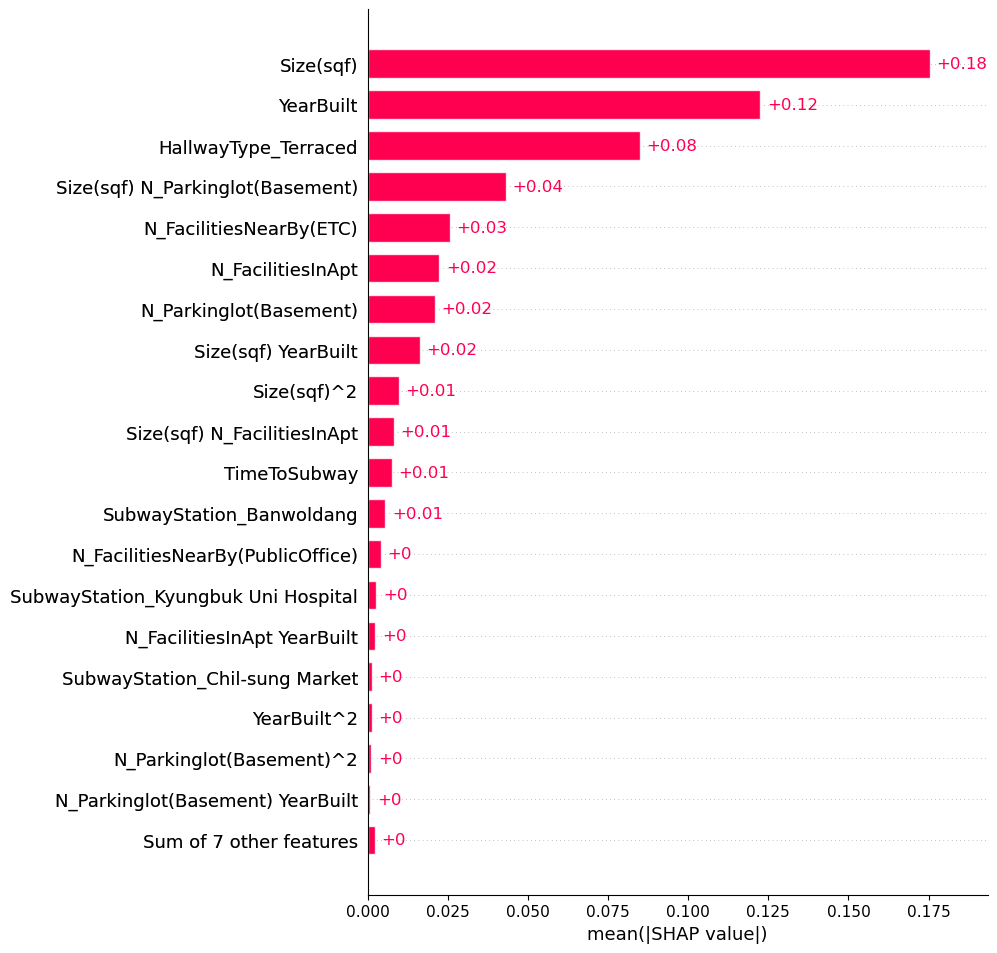

In [224]:
# Use regular SHAP plots for log-scale additive contributions:
shap.plots.bar(shap_values, max_display=20)

**Analysis:** While the XGBoost model ranked HallwayType_Terraced highest in its internal structure, SHAP analysis, which better reflects actual prediction impact, shows Size(sqf) contributes most to price predictions, followed by YearBuilt and HallwayType_Terraced. This suggests size consistently drives apartment value, while age and layout of the building add contextual variance.

Other impactful features include the Size(Sqf) N_Parkinglot(Basement), N_FacilitiesNearBy(ETC) (like shops or services), and N_FacilitiesInApt. All of which add to a property's attractiveness and value. Less influential, but still relevant, are features like Size(Sqf)^2, Size(sqf) N_FacilitiesNearBy(ETC),TimeToSubway, SubwayStation_Banwoldang.

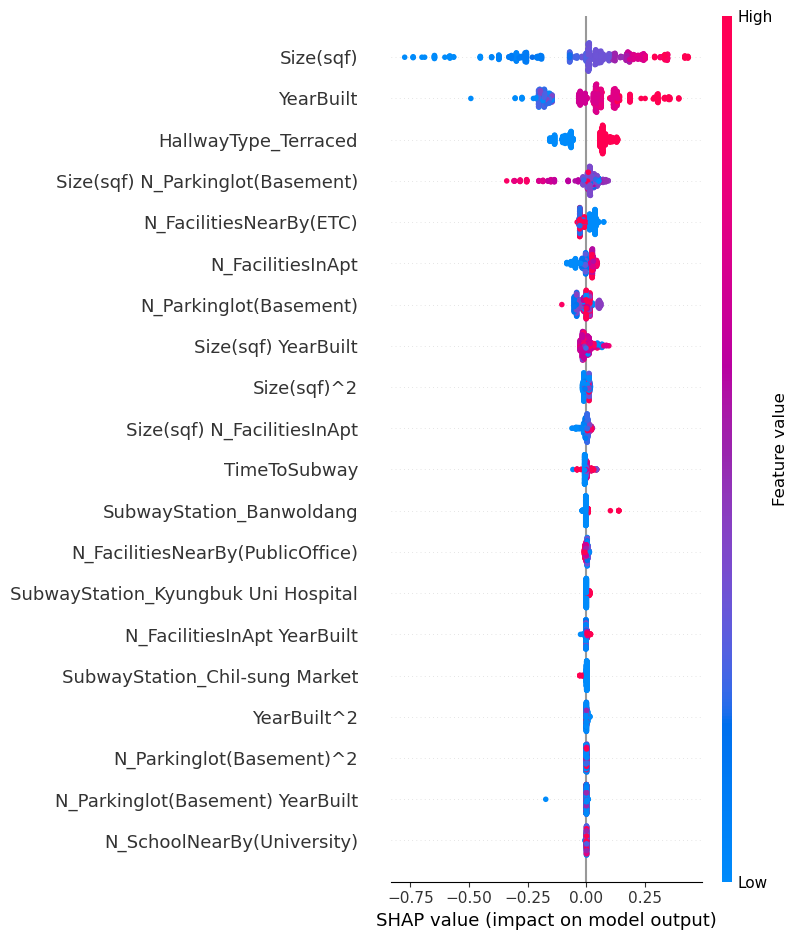

In [225]:
# Impact on Sale Price:
shap.summary_plot(shap_values, X_test_selected)

**Analysis:** This SHAP plot gives us a clear look into which features are really driving the apartment price predictions and how.

- Size Matters Most: As expected, Size(sqf) is the top influencer. Larger apartments tend to push prices up, while smaller ones drag them down.
- Newer is Pricier: YearBuilt is also a major player. Newer buildings increase predicted prices, whereas older ones tend to lower them.
- Hallway Style Matters: The presence of Terraced Hallways appears to positively influence price, likely because they’re perceived as more premium or desirable.
- Basement Parking = Value: The interaction between Size and Basement Parking is interesting. Units with basement parking, especially larger ones, tend to fetch higher predicted prices.
- Location Kinda Matters: Subway station features like Banwoldang and Kyungbuk Uni Hospital appear but have a smaller, more localised impact compared to size and age. Still, they nudge prices depending on proximity or desirability.

Bottom line:
Our model leans heavily on basic real estate fundamentals: bigger, newer apartments with better features (like basement parking and terraced hallways) get higher price predictions. Local factors like nearby subways do play a role but aren’t the main drivers.


Approximate % effect of features on prediction for sample 25:
                             Feature  Approx % Effect
13                         Size(sqf)        -6.895333
2               HallwayType_Terraced        -6.557779
16                         YearBuilt        -3.188066
15                 N_FacilitiesInApt         2.661459
18  Size(sqf) N_Parkinglot(Basement)         2.535344
20               Size(sqf) YearBuilt         2.013587
14            N_Parkinglot(Basement)        -1.139145
10           N_FacilitiesNearBy(ETC)        -0.907716
17                       Size(sqf)^2        -0.721264
19       Size(sqf) N_FacilitiesInApt        -0.406382

Approximate % effect of features on prediction for sample 35:
                             Feature  Approx % Effect
13                         Size(sqf)        11.923035
2               HallwayType_Terraced         7.107503
16                         YearBuilt         4.408992
10           N_FacilitiesNearBy(ETC)         3.708171
14        

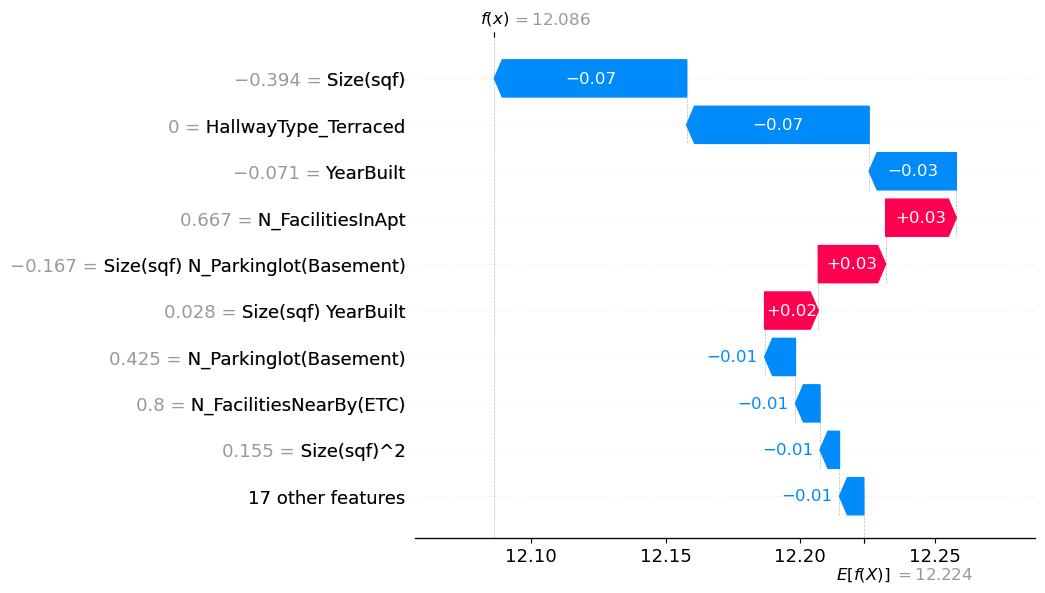

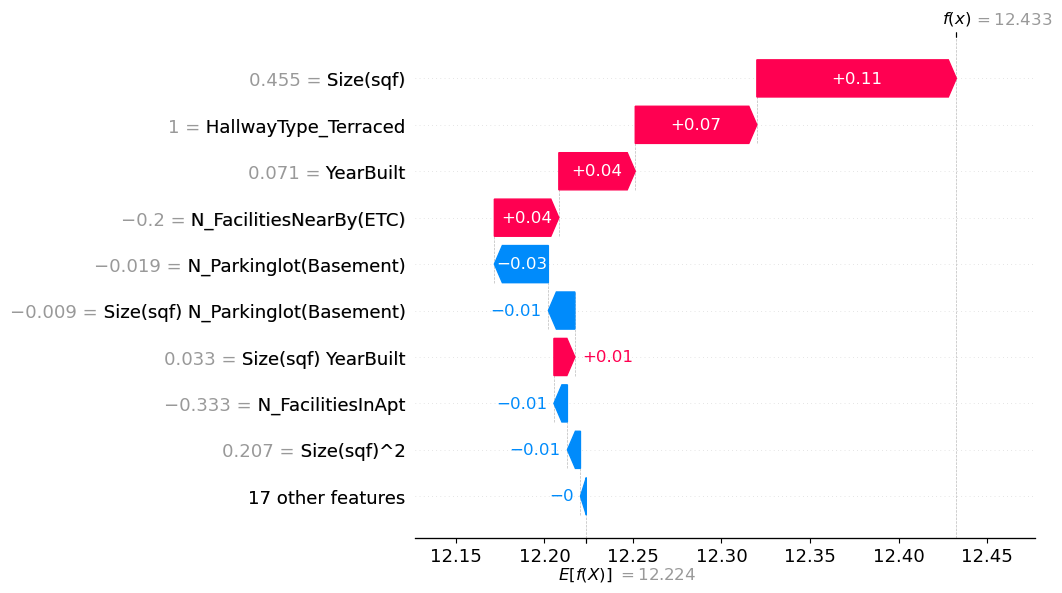

In [226]:
# Print approximate % effect for two samples (idx 25 and 35):
for idx in [25, 35]:
    print(f"\nApproximate % effect of features on prediction for sample {idx}:")
    sample_effects = approx_percent_effects[idx]
    feature_names = X_test_selected.columns
    import pandas as pd
    df_effects = pd.DataFrame({
        "Feature": feature_names,
        "Approx % Effect": sample_effects
    }).sort_values(by="Approx % Effect", key=abs, ascending=False)
    print(df_effects.head(10))

# Waterfall plots for samples (on log scale):
shap.plots.waterfall(shap_values[25])
shap.plots.waterfall(shap_values[35])

In [227]:
# y_test and predictions:
print("\nActual vs Predicted for sample 25:")
print(f"Actual: {y_test.iloc[25]}, Predicted: {y_pred[25]}")

print("\nActual vs Predicted for sample 35:")
print(f"Actual: {y_test.iloc[35]}, Predicted: {y_pred[35]}")


Actual vs Predicted for sample 25:
Actual: 143805, Predicted: 177433.21875

Actual vs Predicted for sample 35:
Actual: 256637, Predicted: 250848.78125


In [228]:
# Original data for indices 25 and 35:
print("\nOriginal feature values (before scaling) for sample 25:")
print(X_test.iloc[25])

print("\nOriginal feature values (before scaling) for sample 35:")
print(X_test.iloc[35])


Original feature values (before scaling) for sample 25:
HallwayType                              Mixed
TimeToSubway                        5min-10min
SubwayStation                          Bangoge
N_FacilitiesNearBy(ETC)                    5.0
N_FacilitiesNearBy(PublicOffice)           5.0
N_SchoolNearBy(University)                 4.0
N_Parkinglot(Basement)                   798.0
YearBuilt                                 2005
N_FacilitiesInApt                            7
Size(sqf)                                  743
Name: 1909, dtype: object

Original feature values (before scaling) for sample 35:
HallwayType                           Terraced
TimeToSubway                            0-5min
SubwayStation                       Banwoldang
N_FacilitiesNearBy(ETC)                    0.0
N_FacilitiesNearBy(PublicOffice)           2.0
N_SchoolNearBy(University)                 2.0
N_Parkinglot(Basement)                   524.0
YearBuilt                                 2007
N_FacilitiesIn

**Analysis Index 25:** For this specific prediction, the model predicts a log price of 12.086, slightly below the average prediction of 12.224. Let’s break down why:

- Price Suppresors:
    - Size(sqf) has the biggest negative impact, lowering the prediction by around 6.9%. This likely means the apartment is on the smaller side.
    - Terraced Hallway contributes a 6.5% drop. In this case, having a terraced hallway doesn’t add perceived value. Maybe it's less appealing in this context.
    - YearBuilt drags the prediction down another 3.2%, suggesting it's an older building.

- Top Price Boosters:
    - N_FacilitiesInApt lifts the prediction by about 2.7%. Having more internal facilities is clearly a plus.
    - The interaction between Size and Basement Parking adds around 2.5%, showing synergy between size and premium features.
    - Size × YearBuilt interaction and other smaller terms (like ETC facilities) also nudge the price upward slightly.

- Net Effect: Despite several positive contributors, the larger negative impacts from size, hallway type, and building age lead to a lower-than-average prediction.

Takeaway: This prediction makes sense. The model penalises smaller, older units with less favourable layout features, even if they come with a few perks like parking or facilities. It shows how nuanced feature interactions play a role in fine-tuning price predictions.

**Analysis Index 35:** The model predicts a log price of 12.433, which is above the average baseline of 12.224. Here’s a quick breakdown of what’s pushing the price up and what’s pulling it down:

- Top Price Boosters:
    - Size(sqf) is the biggest driver, contributing nearly 12% to the final prediction. Larger units clearly carry more weight in the pricing model.
    - Terraced Hallway adds about 7.1%, suggesting this hallway style is seen as a premium or attractive feature.
    - YearBuilt pushes the value up by 4.4%, indicating newer buildings are associated with higher prices.
    - Nearby ETC Facilities (e.g., entertainment or other amenities) also add 3.7%, reinforcing the importance of location perks.

- Price Suppressors:
    - Basement Parking surprisingly reduces the price by 3.0%. Perhaps it’s not as valued in this specific context.
    - The interaction term Size × Parking brings it down further by 1.5%, suggesting size doesn’t scale value as effectively when parking is involved.
    - N_FacilitiesInApt and Size(sqf)^2 both contribute slight negative effects (around 0.75% each), hinting at diminishing returns or trade-offs for over-equipped or oversized units.
    - TimeToSubway reduces the price by 0.71%, so greater distance from public transit slightly lowers perceived value.

Takeaway: Overall, the model sees this apartment as above average in value, primarily because of its larger size, modern build, and premium layout (Terraced hallway). Some features like basement parking and over-scaling bring minor trade-offs, but the positives outweigh the negatives in this prediction.

## Conclusions:

After a thorough comparison of multiple regression models, from ensemble methods like Random Forest and Gradient Boosting to regularised linear models and SVR, **XGBoost** emerged as the most consistent and well-rounded performer. While the improvement after tuning was modest, **XGBoost achieved the lowest MAE (₩38,060) and RMSE (₩47,530)** on the test set, alongside the **highest R² score (0.787)** in predicting log-transformed sale prices. It also maintained a **balanced MAPE (18.78%)**, confirming its reliability across price ranges.

- Model Performance Insights:
    - All ensemble tree-based models outperformed Ridge and SVR in terms of R² and error metrics.
    - XGBoost slightly edged out Gradient Boosting and CatBoost after tuning, showing it captured feature interactions more effectively.
    - Compared to a simple baseline using Grouped Mean by Size, XGBoost reduced MAE by over 55% and massively improved R² from -0.02 to 0.79, proving the advantage of using a multi-feature ML model.

- Error & Residual Patterns:
    - Residuals were fairly well-distributed, with no major sign of systematic bias though predictions became less precise in higher price brackets (> ₩250k).
    - Most predictions were classified as accurate, but underpricing tended to appear more in the ₩100k–₩300k range. Overpricing was more spread out, especially in mid-range prices.

- Model Interpretability (SHAP):
    - Size(sqf) was consistently the most influential feature, with newer buildings (YearBuilt) and Terraced hallways also playing major roles in boosting prices.
    - Basement parking, proximity to ETC facilities, and subway access had more localised or interaction-based influence, sometimes increasing or slightly reducing predictions depending on context.
    - The model captured nuanced effects. For instance, larger size didn’t always mean higher price, especially when combined with certain other features like parking or excess amenities.

- Prediction Examples:
    - Smaller, older apartments with less favourable layouts were predicted below average, even when they had some premium features.
    - On the flip side, larger, newer units with desirable layouts (Terraced) were consistently priced higher by the model, though some features like basement parking occasionally acted as mild price suppressors depending on combinations.

## Recommendations:

1. **Apply the model cautiously to high-end listings**:

    For premium properties priced above ₩250,000, model accuracy decreases due to greater price variability.

    *Action:* Combine the model’s estimate with expert appraisals and enhanced listing data (e.g., floor level, view quality, interior finish level) to improve confidence and pricing precision.

2. **Highlight premium traits in marketing**:

    Larger apartments, newer buildings, and those with terraced hallway types command higher prices.

    *Action:* Highlight these features explicitly in marketing materials and filter priority properties for promotion using the model’s top feature drivers.

3. **Use model explanations for buyer-seller transparency**:

    SHAP explanations (e.g., for Index 25 and 35) show which features drive pricing and why. This builds credibility with clients.

    *Action:* Integrate these visual explanations into client presentations or team dashboards to justify prices and support negotiations with data.

4. **Consider adding neighbourhood-level features**:

    External factors like school quality, crime rates, or urban development explain variance that internal features alone cannot.

    *Action:* Partner with local data providers or open government sources to enrich listings with these features. Pilot this in high-variance zones first to evaluate impact on pricing accuracy.

In [229]:
# Save model (pickle):
estimator = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor())
])

# Fit on log-transformed y:
estimator.fit(X_train, y_train_log)

# Save pipeline:
pickle.dump(estimator, open('xgb_daegu_apartments_pipeline.sav', 'wb'))

# To load later:
loaded_estimator = pickle.load(open('xgb_daegu_apartments_pipeline.sav', 'rb'))

# Predict:
y_pred_log = loaded_estimator.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [230]:
# Transform features:
X_train_processed = preprocessor.fit_transform(X_train)

# Fit model on log(y):
model = XGBRegressor()
model.fit(X_train_processed, y_train_log)

# Save:
joblib.dump(preprocessor, 'preprocessor_daegu_apartments.pkl')
joblib.dump(model, 'model_daegu_apartments.pkl')

# Load later:
preprocessor_loaded = joblib.load('preprocessor_daegu_apartments.pkl')
model_loaded = joblib.load('model_daegu_apartments.pkl')

# Predict:
X_test_processed = preprocessor_loaded.transform(X_test)
y_pred_log = model_loaded.predict(X_test_processed)
y_pred = np.expm1(y_pred_log)